## testing out the biomass notebook for modeling & application

In [89]:

#----------------------------------------------#
# loading packages
#----------------------------------------------#

#require(pacman)
#pacman::p_load(randomForest, raster,rgdal)


# 2.6 ICESat-2 biomass 30m ATL08

#### i) Description
#### This notebook use GEDI-derived AGB models for estimating sparse ICESat-2 AGB using 30 m ATL08 product.

#### ii) How the algorithm works?
#### GEDI-derived AGB models are loaded in R and applied over the ICESat-2 30m ATL08 data. 

#### iii) Inputs
####  - rds_models: list of GEDI-derived AGB model paths
####  - models_id: models id
####  - ice2_30_atl08: list containing the path to the ATL08 files
####  - offset: offset applied in the model

#### iii) Outputs
####  -ICEsat-2 AGB estimates are data.frame object in R

#----------------------------------------------#
############# functions ########################
#----------------------------------------------#
#GEDI2AT08AGB<-function(rds_models,models_id,ice2_30_atl08_path, offset=100){
  
# rds models
rds_models<-list.files("/projects/icesat2_boreal/notebooks/biomass_models", ".rds", full.names = T)

# adding model ids
models_id<-names(rds_models)<-paste0("m",1:length(rds_models))


#ice2_30_atl08_path <- ice2_30_atl08_files[length(ice2_30_atl08_files)-2]
#    ice2_30_atl08_path_short <- ice2_30_atl08_files_short[length(ice2_30_atl08_files)-2]
#    print(ice2_30_atl08_path_short)
#    tile_id_csv <- unlist(strsplit(ice2_30_atl08_path_short, 'atl08_filt_topo_landsat_20210813_'))[2]
#    print(tile_id_csv)
#    tile_id <- unlist(strsplit(tile_id_csv, '.csv'))
#    print(tile_id)
#    topo_stack <- stack(topo_files[grep(tile_id, topo_files)])
#    l8_stack <- stack(l8_files[grep(tile_id, l8_files)])
#    stack<-crop(l8_stack,extent(topo_stack));stack<-stack(stack,topo_stack)
#    output <- paste('/projects/my-public-bucket/biomaps_out/', ice2_30_atl08_files_short[i], '.tif', sep='')

  # rds_models
  names(rds_models)<-models_id
  # read table
  xtable<-read.table(ice2_30_atl08_path, sep=",", head=T)
  xtable_i<-na.omit(as.data.frame(xtable))
  names(xtable_i)[1:11]<-c("lon","lat","RH_25","RH_50","RH_60","RH_70","RH_75","RH_80","RH_90","RH_95","RH_98")
  
  #
offset <- 100
  xtable_sqrt<-xtable_i[3:11]+offset

  #names(xtable_sqrt)<-paste0("sqrt(",names(xtable_sqrt),")")
  #xtable_sqrt<-cbind(xtable_sqrt,AGB, SE, model_id)
  #xtable_sqrt<-xtable_i
  #xtable_sqrt[,3:12]<-xtable_sqrt[,3:12]

  # apply models by id
  xtable_sqrt$AGB<-NA
  xtable_sqrt$SE<-NA
  xtable_sqrt$model_id<-names(rds_models)[1]
  # get unique ids
  ids<-unique(xtable_sqrt$model_id)

head(xtable_sqrt)
  for (i in ids){
      
    # subset data for model id
    model_i<-readRDS(rds_models[names(rds_models)==i])
    
    # SE
    xtable_sqrt$SE[xtable_sqrt$model_id==i] <- summary(model_i)$sigma
    
    # AGB prediction
    xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-predict(model_i, newdata=xtable_sqrt[xtable_sqrt$model_id==i,])
    
    #adjust for offset in model fits (note, this was 20 for ages, and now it's 100; essentially we added to all the height metrics so they would never be negative)
    #xtable_sqrt$AGB[xtable_sqrt$model_id==i] <- xtable_sqrt$AGB[xtable_sqrt$model_id==i]+offset
    
    #define C
    C <- mean(model_i$fitted.values)/mean(model_i$model$`sqrt(AGBD)`)
    
    #we multiply by C in case there is a systematic over or under estimation in the model (bias correction)
    xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-C*xtable_sqrt$AGB[xtable_sqrt$model_id==i]^2
    #print(head(xtable_sqrt$AGB[xtable_sqrt$model_id==i]))
  }
  #xtable2<-xtable_sqrt[,c(names(xtable_i),"AGB","SE")]
  xtable2<-cbind(xtable, xtable_sqrt$AGB, xtable_sqrt$SE)#[,c(names(xtable_i),"AGB","SE")]
ncol <- ncol(xtable2)
  colnames(xtable2)[(ncol-1):ncol]<-c('AGB', 'SE')
  #return(xtable2)
#head(xtable2)
#}

,RH_25,RH_50,RH_60,RH_70,RH_75,RH_80,RH_90,RH_95,RH_98,AGB,SE,model_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>
1,101.1158,101.4799,102.4531,103.2456,103.3162,103.5267,107.7503,113.5797,114.3537,NA,NA,m1
2,104.5338,106.1779,107.2745,107.9626,108.7281,108.8855,109.9413,111.3166,111.5344,NA,NA,m1
3,102.0893,104.3308,104.6653,105.1992,105.6949,106.0403,106.9764,109.1399,110.8858,NA,NA,m1
4,103.2824,105.4408,106.0392,106.9250,107.5177,107.5666,108.1207,109.8834,110.4473,NA,NA,m1
5,100.8002,100.9839,101.5034,102.0229,102.2827,102.3055,102.3513,102.3878,102.3970,NA,NA,m1
6,101.0067,101.6091,101.8784,102.5218,102.9059,103.0446,103.3031,103.4645,103.5049,NA,NA,m1


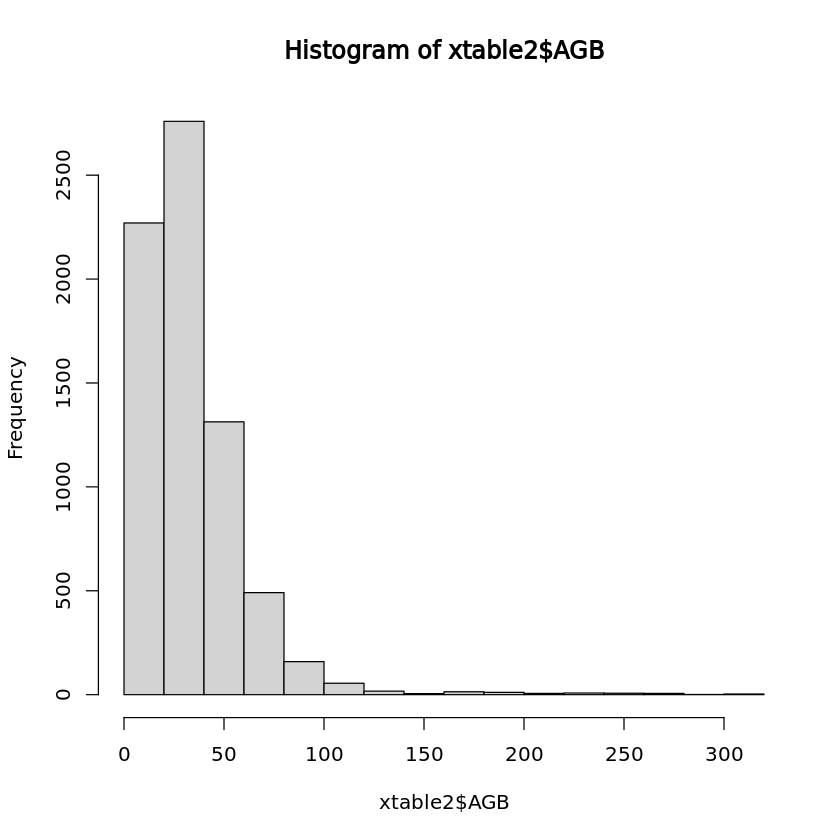

In [90]:
#print(names(xtable_i))
hist(xtable2$AGB)

In [54]:
for (i in ids){
    #print(i)
    # subset data for model id
    model_i<-readRDS(rds_models[names(rds_models)==i])
    #print(model_i)
    # SE
    xtable_sqrt$SE[xtable_sqrt$model_id==i] <- summary(model_i)$sigma
    
    # AGB prediction
    xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-predict(model_i, newdata=xtable_sqrt[xtable_sqrt$model_id==i,])
    
    #adjust for offset in model fits (note, this was 20 for ages, and now it's 100; essentially we added to all the height metrics so they would never be negative)
    #xtable_sqrt$AGB[xtable_sqrt$model_id==i] <- xtable_sqrt$AGB[xtable_sqrt$model_id==i]+offset
    
    #define C
    C <- mean(model_i$fitted.values)/mean(model_i$model$`sqrt(AGBD)`)
    #we multiply by C in case there is a systematic over or under estimation in the model (bias correction)
    xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-C*xtable_sqrt$AGB[xtable_sqrt$model_id==i]^2
    #print(head(xtable_sqrt$AGB[xtable_sqrt$model_id==i]))
  }

[1] 1.002677


In [ ]:


# 2.7 ICESat-2 biomass algorithm development

#### i) Description
#### This notebook uses the sparse ICESat-2 AGB estimates and remote sensing covariates data (ex. extracted from ALOS-2, Landsat 8 OLI, Sentinel 2A...etc) for calibrating and testing AGB models using parametric and non-parametric statistical modeling approaches, such as OLS, RF, k-NN, SVM and ANN. 

#### ii) How the algorithm works?
#### Users must to select the number of bootstrapping runs (ex. 100). In each run, the original dataset is divided into training (ex. 70%) and testing (ex. 30%) datastes for model calibration and validation. Users can select if they want to create the training and testing dataset using a random or stratified random sampling approach. R2, RMSE and MD are computed based on the training dataset. 

#### iii) Inputs
####  -rep: number of bootstrapping runs
####  -y: vector of the response variable in the dataset (ex. "g_agbm")
####  -x: dataframe containing the name of the covariates
####  -s_train: percentage used selected the training dataset (ex.70), 
####  -stack: stack of covar
####  -strat_random: If TRUE the original dataset will be splitted into training and testing using the stratified random approach (bins are defined by the quartiles). Otherwise, the random approach will be used. 

#### iii) Outputs
#### Maps of AGB (mean and sd)
#### Maps (mean and sd) of the prediction accuracy (RMSE, bias and R2 for the testig datasets)
#### Legend:
#### agb_mean = mean of the AGB predictions 
#### agb_sd = sd of the AGB predictions (n = rep)
#### armse_map_mean = mean of absolute RMSE values
#### armse_map_sd = sd of absolute RMSE values
#### rrmse_map_mean = mean of relative RMSE values
#### rrmse_map_sd = sd of relative RMSE values
#### abias_map_mean = mean of absolute RMSE values
#### abias_map_sd = sd of absolute RMSE values
#### rbias_map_mean = mean of relative of bias values
#### rbias_map_sd = sd of relative bias values
#### r2_map_mean = mean of r2 values
#### r2_map_sd = sd of r2 values 


#----------------------------------------------#
############# functions ########################
#----------------------------------------------#

# stats
StatModel <- function( obs, est){
  xy<-na.omit(cbind(obs,est))
  obs<-xy[,1]
  est<-xy[,2]
  rmse <- sqrt( sum(( est - obs )^2)/length(obs) ) # Root mean square error
  bias <- mean( est - obs ) # bias
  rmseR <- 100 * sqrt( sum(( est - obs )^2)/length(obs) ) / mean( obs )
  biasR <- 100 * mean( est - obs ) / mean( obs )
  r <- cor(est,obs)
  r2<-summary(lm(obs~est))$r.squared
  Stats<-data.frame( Stat=c("rmse","rmseR","bias","biasR","r","r2"),
                     Values=round(c(rmse,rmseR,bias,biasR,r,r2),2)) 
  return(Stats)
}

stratRandomSample<-function(agb=y,breaks, p){
  #require(data.table)
  n<-length(agb)
  ids<-1:n
  s<-round(n*p)
  agb[agb==0]<-0.0000000001
  ids_cut<-cut(agb,breaks=breaks, labels=F)
  df<-cbind(agb,ids,ids_cut)
  df<-data.table(df[!is.na(df[,1]),])
  number_sample<-ceiling(s/(length(breaks)-1))
  sel_all<-df[,.SD[sample(.N, min(number_sample,.N), replace = T)],by=ids_cut]
  return(ids_selected=sel_all$ids)
}


In [ ]:
# modeling 
agbModelingMapping<-function(x=x,y=y,se=NULL,s_train=70, rep=10,stack=stack,strat_random=TRUE,output){
  
  pb <- txtProgressBar(min = 0, max = rep, style = 3)
  
  stats_df<-NULL
  n<-length(x)
  ids<-1:n
  map_pred<-NULL
  
  #p_load("VSURF")
  #varsel <- VSURF(y=y, x=x, ntree=1000)
  #varnames<-colnames(x)[varsel$varselect.interp]
  stack_df <- na.omit(as.data.frame(stack, xy=TRUE))
  stack_df$grid_id<-1:nrow(stack_df)
  
  #i=10
  i.s=0
  #j=1
  
  for (j in 1:rep){
    i.s<-i.s+1
    setTxtProgressBar(pb, i.s)
    
    set.seed(j)
    if ( strat_random==TRUE){
      trainRowNumbers<-stratRandomSample(agb=y,breaks=quantile(y, na.rm=T), p=s_train/100)
    } else {
      trainRowNumbers<-sort(sample(ids,round(n*s_train/100), T))
    }
    print(str(trainRowNumbers))
    print('n:', n)
    # Step 2: Create the training  dataset
    # select % of data to training and testing the models
    trainData.x <- x[trainRowNumbers,]
    trainData.y <- y[trainRowNumbers]
    
    
    # Step 3: Create the test dataset
    # select % of the data for validation
    testData.x <- x[!row.names(x) %in% trainRowNumbers,]
    testData.y <- y[!row.names(x) %in% trainRowNumbers]
    
    # rf modeling
    set.seed(j)
    
    fit.rf <- randomForest(y=trainData.y, x=trainData.x, ntree=1000)
    pred.rf<-predict(fit.rf, newdata=testData.x) # 
    #fit.rf <- randomForest(y=trainData.y, x=trainData.x[,varnames], ntree=1000)
    #pred.rf<-predict(fit.rf, newdata=testData.x[,varnames]) # 
    stats.rf<-cbind(method=rep("RF",6), rep=rep(j,6), StatModel(testData.y,pred.rf))
    
    # model validation stats
    stats_df<-rbind(stats_df,
                    stats.rf)
    row.names(stats_df)<-1:nrow(stats_df)
    
    # mapping
    #map_i<-cbind(stack_df[,1:2],agb=predict(fit.rf, newdata=stack_df[,varnames]), rep=i)
    map_i<-cbind(stack_df[,1:2],agb=predict(fit.rf, newdata=stack_df), rep=j, grid_id=stack_df$grid_id)
    map_pred<-rbind(map_pred,map_i)
    
  }
  
  
  mean_map<-tapply(map_pred$agb,map_pred$grid_id,mean)
  sd_map<-tapply(map_pred$agb,map_pred$grid_id,sd)
  
  
  agb_maps <- rasterFromXYZ(cbind(stack_df[,1:2],
                                  agb_mean=mean_map,
                                  agb_sd=sd_map,
                                  armse_map_mean=mean(stats_df[stats_df[,3]=="rmse",4]),
                                  armse_map_sd=sd(stats_df[stats_df[,3]=="rmse",4]),
                                  
                                  rrmse_map_mean=mean(stats_df[stats_df[,3]=="rmseR",4]),
                                  rrmse_map_sd=sd(stats_df[stats_df[,3]=="rmseR",4]),
                                  
                                  abias_map_mean=mean(stats_df[stats_df[,3]=="bias",4]),
                                  abias_map_sd=sd(stats_df[stats_df[,3]=="bias",4]),
                                  
                                  rbias_map_mean=mean(stats_df[stats_df[,3]=="bias",4]),
                                  rbias_map_sd=sd(stats_df[stats_df[,3]=="bias",4]),
                                  
                                  r2_map_mean=mean(stats_df[stats_df[,3]=="r2",4]),
                                  r2_map_sd=sd(stats_df[stats_df[,3]=="r2",4])))
  
  close(pb)
  return(agb_maps)
}

In [12]:
ice2_30_atl08_path <- ice2_30_atl08_files[length(ice2_30_atl08_files)-2]
    ice2_30_atl08_path_short <- ice2_30_atl08_files_short[length(ice2_30_atl08_files)-2]
    print(ice2_30_atl08_path_short)
    tile_id_csv <- unlist(strsplit(ice2_30_atl08_path_short, 'atl08_filt_topo_landsat_20210813_'))[2]
    print(tile_id_csv)
    tile_id <- unlist(strsplit(tile_id_csv, '.csv'))
    print(tile_id)
    topo_stack <- stack(topo_files[grep(tile_id, topo_files)])
    l8_stack <- stack(l8_files[grep(tile_id, l8_files)])
    stack<-crop(l8_stack,extent(topo_stack));stack<-stack(stack,topo_stack)
    output <- paste('/projects/my-public-bucket/biomaps_out/', ice2_30_atl08_files_short, '.tif', sep='')
#mapBoreal<-function(rds_models,
#                    models_id,
#                    ice2_30_atl08_path, 
#                    offset=0,
#                    s_train=70, 
#                    rep=10,
#                    stack,
#                    strat_random=TRUE,
#                    output){
rds_models <- rds_models
models_id <- models_id
ice2_30_atl08_path <- ice2_30_atl08_path
offset=0
s_train=70 
rep=10
stack
strat_random=FALSE
  # apply GEDI models 

#GEDI2AT08AGB<-function(rds_models,models_id,ice2_30_atl08_path, offset=100){
  
  # rds_models
  names(rds_models)<-models_id
  # read table
  xtable<-read.table(ice2_30_atl08_path, sep=",", head=T)
  xtable_i<-na.omit(as.data.frame(xtable))
col_names <- c("lon","lat","RH_25","RH_50","RH_60","RH_70","RH_75","RH_80","RH_90","RH_95","RH_98")
  names(xtable_i)[1:11]<-col_names
  
  #
  xtable_sqrt<-sqrt(xtable_i[col_names]+offset)
  names(xtable_sqrt)<-paste0("sqrt(",names(xtable_sqrt),")")
  #xtable_sqrt<-cbind(xtable_i,xtable_sqrt)
  xtable_sqrt<-xtable_i
  xtable_sqrt[,3:12]<-xtable_sqrt[,3:12]
  
  # get unique ids
  ids<-unique(xtable_sqrt$model_id)

  # apply models by id
  xtable_sqrt$AGB<-NA
  xtable_sqrt$SE<-NA
  
  #i=ids[1]
  for (i in ids){
    
    # subset data for model id
    model_i<-readRDS(rds_models[names(rds_models)==i])
    
    # SE
    xtable_sqrt$SE[xtable_sqrt$model_id==i] <- summary(model_i)$sigma
    
    # AGB prediction
    xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-predict(model_i, newdata=xtable_sqrt[xtable_sqrt$model_id==i,])
    
    #adjust for offset in model fits (note, this was 20 for ages, and now it's 100; essentially we added to all the height metrics so they would never be negative)
    #xtable_sqrt$AGB[xtable_sqrt$model_id==i] <- xtable_sqrt$AGB[xtable_sqrt$model_id==i]+offset
    
    #define C
    C <- mean(model_i$fitted.values)/mean(model_i$model$`sqrt(AGBD)`)
    
    #we multiply by C in case there is a systematic over or under estimation in the model (bias correction)
    xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-C*xtable_sqrt$AGB[xtable_sqrt$model_id==i]^2
    #print(head(xtable_sqrt$AGB[xtable_sqrt$model_id==i]))
  }
  xtable2<-xtable_sqrt[,c(names(xtable_i),"AGB","SE")]
  colnames(xtable2)[3:12]<-colnames(xtable)[3:12]
  xtable <- xtable2
#}
str(xtable)
  xtable<-GEDI2AT08AGB(rds_models=rds_models,
                       models_id=models_id,
                       ice2_30_atl08_path=ice2_30_atl08_path, 
                       offset=offset)
  
  # run 
    pred_vars <- c('elevation', 'slope', 'tsri', 'tpi', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'NBR', 'NBR2', 'TCW')

#maps<-agbModelingMapping(x=xtable[pred_vars],
#                           y=xtable$AGB,
#                           se=xtable$SE,
#                           s_train=s_train,
#                           rep=rep,
#                           stack=stack,
#                           strat_random=strat_random)

#  writeRaster(maps,output,overwrite=T)
#  return(maps)
#}

[1] "atl08_filt_topo_landsat_20210813_986.csv"
[1] "986.csv"
[1] "986"


class      : RasterStack 
dimensions : 3000, 3000, 9e+06, 23  (nrow, ncol, ncell, nlayers)
resolution : 30, 30  (x, y)
extent     : 4598522, 4688522, 6183304, 6273304  (xmin, xmax, ymin, ymax)
crs        : +proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs 
names      : Blue, Green, Red, NIR, SWIR, NDVI, SAVI, MSAVI, NDMI, EVI, NBR, NBR2, TCB, TCG, TCW, ... 


Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”


'data.frame':	7125 obs. of  37 variables:
 $ lon      : num  -69.7 -69.7 -69.7 -69.7 -69.7 ...
 $ lat      : num  51.3 51.3 51.3 51.3 51.7 ...
 $ rh25     : num  1.12 4.53 2.09 3.28 0.8 ...
 $ rh50     : num  1.48 6.178 4.331 5.441 0.984 ...
 $ rh60     : num  2.45 7.27 4.67 6.04 1.5 ...
 $ rh70     : num  3.25 7.96 5.2 6.92 2.02 ...
 $ rh75     : num  3.32 8.73 5.69 7.52 2.28 ...
 $ rh80     : num  3.53 8.89 6.04 7.57 2.31 ...
 $ rh90     : num  7.75 9.94 6.98 8.12 2.35 ...
 $ h_can    : num  13.58 11.32 9.14 9.88 2.39 ...
 $ h_max_can: num  14.4 11.5 10.9 10.4 2.4 ...
 $ geometry : chr  "POINT (4655531.98790389 6240788.991718134)" "POINT (4655562.074760491 6240788.097300721)" "POINT (4655622.248133902 6240786.300359203)" "POINT (4655652.33658551 6240785.451901416)" ...
 $ elevation: num  460 459 457 456 513 ...
 $ slope    : num  3.47 2.3 3.34 4.75 1.83 ...
 $ tsri     : num  0.00821 0.03955 0.55356 0.54681 0.10158 ...
 $ tpi      : num  -0.447083 0.000916 0.730438 1.031708 -0.901611

Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”


In [11]:
xtable<-GEDI2AT08AGB(rds_models=rds_models,
                       models_id=models_id,
                       ice2_30_atl08_path=ice2_30_atl08_path, 
                       offset=offset)

str(xtable$AGB)
  # run 
    pred_vars <- c('elevation', 'slope', 'tsri', 'tpi', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'NBR', 'NBR2', 'TCW')

#maps<-agbModelingMapping(x=xtable[pred_vars],
#                           y=xtable$AGB,
#                           se=xtable$SE,
#                           s_train=s_train,
#                           rep=rep,
#                           stack=stack,
#                           strat_random=strat_random)

#  writeRaster(maps,output,overwrite=T)
#  return(maps)
#}

Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”


 logi [1:7125] NA NA NA NA NA NA ...


In [3]:
library(randomForest)
library(raster)
library(rgdal)
library(data.table)

In [6]:
#----------------------------------------------#
# Importing datasets
#----------------------------------------------#
# rds models
rds_models<-list.files("/projects/icesat2_boreal/notebooks/biomass_models/", ".rds", full.names = T)

# adding model ids
models_id<-names(rds_models)<-paste0("m",1:length(rds_models))

# ic2 alt08 files
ice2_30_atl08_files_short <- list.files("/projects/shared-buckets/nathanmthomas/out_tiles/", pattern='*.csv')
print(length(ice2_30_atl08_files_short))
ice2_30_atl08_files <- list.files("/projects/shared-buckets/nathanmthomas/out_tiles", pattern='*.csv', full.names=T)
print(ice2_30_atl08_files[1])

#ice2_30_atl08_path<-"/projects/shared-buckets/nathanmthomas/out_tiles/atl08_filt_topo_landsat_20210806_986.csv"

# stack
topo_files <- list.files("/projects/shared-buckets/nathanmthomas/Topo", pattern='*.tif', full.names=T)
print(length(topo_files))
print(topo_files[1])

l8_files <- list.files("/projects/shared-buckets/nathanmthomas/Landsat", pattern='*.tif', full.names=T)
print(length(l8_files))
print(l8_files[1])
#topo_stack<-stack("/projects/shared-buckets/nathanmthomas/Topo/Copernicus_986_covars_cog_topo_stack.tif")
#l8_stack<-stack("/projects/shared-buckets/nathanmthomas/Landsat/Landsat8_986_comp_cog_2015-2020_dps.tif")
#stack<-crop(l8_stack,extent(topo_stack));stack<-stack(stack,topo_stack)

# output file

#output<-"/projects/my-public-bucket/biomaps_out/AGBmaps_stack.tif"


[1] 37
[1] "/projects/shared-buckets/nathanmthomas/out_tiles/atl08_filt_topo_landsat_20210813_839.csv"
[1] 59
[1] "/projects/shared-buckets/nathanmthomas/Topo/Copernicus_421_covars_cog_topo_stack.tif"
[1] 37
[1] "/projects/shared-buckets/nathanmthomas/Landsat/Landsat8_839_comp_cog_2015-2020_dps.tif"


In [ ]:

#for(i in 1:length(ice2_30_atl08_files)){
i=1
    ice2_30_atl08_path <- ice2_30_atl08_files[length(ice2_30_atl08_files)-2]
    ice2_30_atl08_path_short <- ice2_30_atl08_files_short[length(ice2_30_atl08_files)-2]
    print(ice2_30_atl08_path_short)
    tile_id_csv <- unlist(strsplit(ice2_30_atl08_path_short, 'atl08_filt_topo_landsat_20210813_'))[2]
    print(tile_id_csv)
    tile_id <- unlist(strsplit(tile_id_csv, '.csv'))
    print(tile_id)
    topo_stack <- stack(topo_files[grep(tile_id, topo_files)])
    l8_stack <- stack(l8_files[grep(tile_id, l8_files)])
    stack<-crop(l8_stack,extent(topo_stack));stack<-stack(stack,topo_stack)
    output <- paste('/projects/my-public-bucket/biomaps_out/', ice2_30_atl08_files_short[i], '.tif', sep='')
    maps<-mapBoreal(rds_models=rds_models,
                models_id=models_id,
                ice2_30_atl08_path=ice2_30_atl08_path, 
                offset=100.0,
                s_train=70, 
                rep=10,
                stack=stack,
                strat_random=FALSE,
                output=output)
    
    if(i==1){
        plot(maps)
    }
#}